## RGB ANALYSIS
This notebook is for comparison of the RGB channels for experimental and simulated images to see if the watershed algorithm performs any better in creating annotations of comet outlines.

In [19]:
import numpy as np
#
def rgba2rgb(rgba, background = (255, 255, 255)):
    '''
    Function to convert RGBA images into RGB format. Input RGBA image (and background); output RGB image.
    '''
    rows, cols, chans = rgba.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
            return rgba
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 4, 'RGBA image must have 4 channels.'
    #
    rgb = np.zeros((rows, cols, 3), dtype = 'float32')
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    #
    a = np.asarray(a, dtype='float32')/255.0
    #
    R, G, B = background
    #
    rgb[:, :, 0] = r*a + (1.0 - a)*R
    rgb[:, :, 1] = g*a + (1.0 - a)*G
    rgb[:, :, 2] = b*a + (1.0 - a)*B
    #
    return np.asarray(rgb, dtype = np.uint8)
#
def rgb2grey(rgb, negative = 0):
    '''
    Convert RGB image to greyscale. Input RGB (and flag indicating negative required), output greyscale image.
    '''
    rows, cols, chans = rgb.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    grey = np.zeros((rows, cols), dtype = 'float32')
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #
    grey[:, :] = (0.2125*(r*negative + (negative - 1.0)*r) + 
                  0.7154*(g*negative + (negative - 1.0)*g) + 
                  0.0721*(b*negative + (negative - 1.0)*b))
    #
    return np.asarray(grey, dtype = np.uint8)
#
def ceilDiv(a, b):
    '''
    Return a//b rounded up.
    '''
    ceiling = -(-a//b)
    return ceiling

def rgbSeperate(rgb, filename, withPlots = True):
    '''
    Seperate RGB image into the R, G, B components and plot image in each of these individual channels.
    '''
    rows, cols, chans = rgb.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    rMax = np.max(r)
    gMax = np.max(g)
    bMax = np.max(b)
    print("max pixel intensities for the red, green and blue channels are: ", rMax, gMax, bMax)
    #
    if withPlots == True:
        plt.figure(figsize = (12, 9))
        plt.subplot(2, 2, 1)
        plt.title("raw image" + str(filename))
        plt.imshow(rgb, cmap='afmhot')
        plt.subplot(2, 2, 2)
        plt.title("red channel")
        plt.imshow(r, cmap='afmhot')
        plt.subplot(2, 2, 3)
        plt.title("green channel")
        plt.imshow(g, cmap='afmhot')
        plt.subplot(2, 2, 4)
        plt.title("blue channel")
        plt.imshow(b, cmap='afmhot')
        plt.show()
        #
        nBins = 256
        plt.figure(figsize = (12, 9))
        plt.title("intensity histograms for " + str(filename))
        plt.subplot(4, 1, 1)
        plt.hist(imgRGB.flatten(), bins = nBins, color = 'k')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 2)
        plt.hist(r.flatten(), bins = nBins, color = 'r')
        plt.yscale("log")
        plt.xlim(-1, 256)
        #
        plt.subplot(4, 1, 3)
        plt.hist(g.flatten(), bins = nBins, color = 'g')
        plt.yscale("log")
        plt.xlim(-1, 256)
        #
        plt.subplot(4, 1, 4)
        plt.hist(b.flatten(), bins = nBins, color = 'b')
        plt.yscale("log")
        plt.xlim(-1, 256)
        #

    return r, g, b

## Process image to get RGB and grey versions and plot with intensity spectrums

Date and time  2021-06-24 13:04:09.904380
Type of raw image file is uint8
Type of greyscale image file is uint8
Number of rows 1040 of columns 1392 of pixels 1447680 and depth 3
Maximum pixel intensity of raw image 255
Maximum pixel intensity of grey image 255
 
Number of thresholds 2
Number of rows in figure 3
 


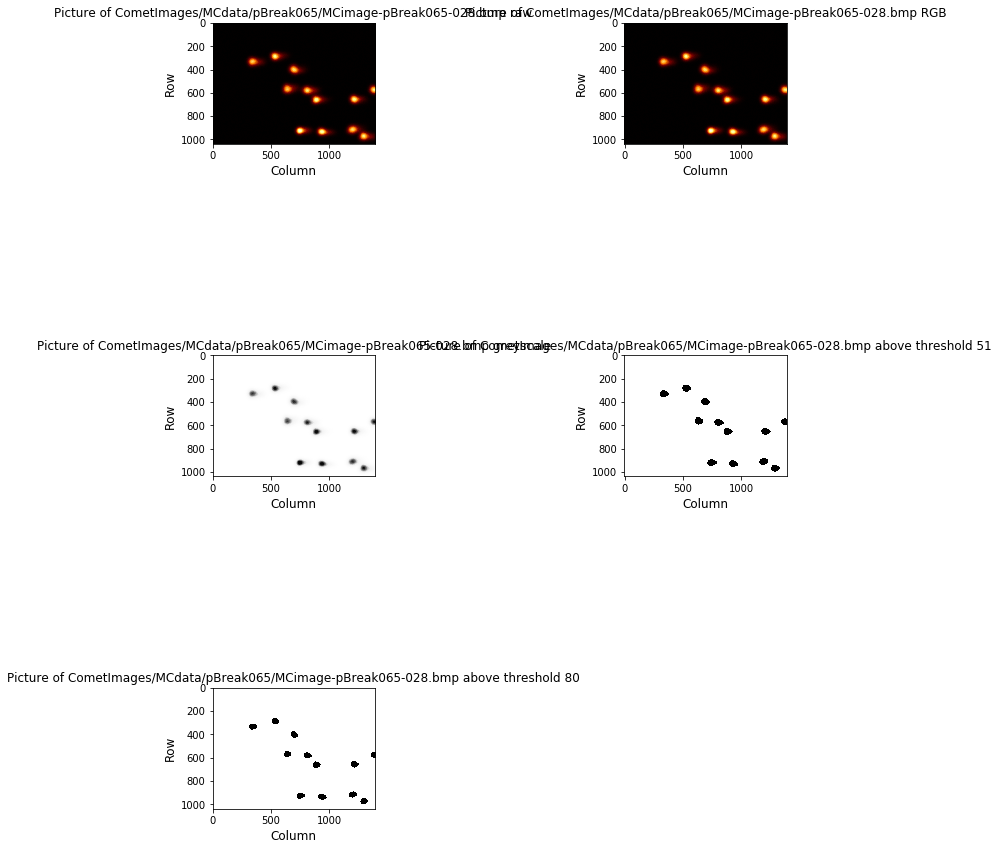

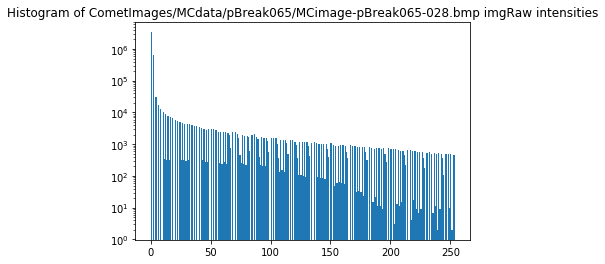

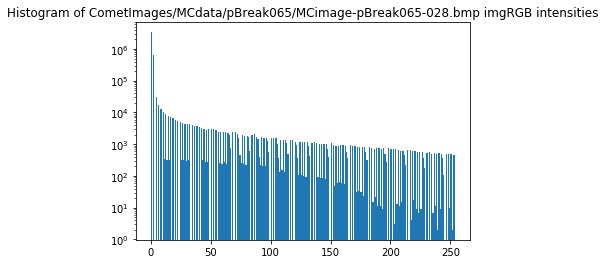

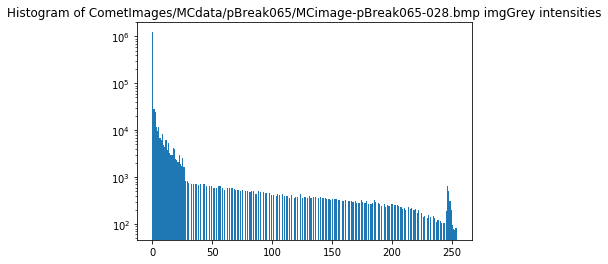

In [40]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import sys
import numpy as np
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
%matplotlib inline
# 
imFile = "CometImages/MCdata/pBreak065/MCimage-pBreak065-028.bmp"
#imFile = "CometImages/CA210609/Collated/4GyB/bmp/4GyB0020.bmp"
#imFile = "CometImages/exp-train/comets34.bmp"

imgRaw = plt.imread(imFile)
#
# Number of rows and columns. Depth is 3 for RGB, 4 for RGBA image. A is opacity (alpha)
nRows = imgRaw.shape[0] 
nCols = imgRaw.shape[1]
nDepth = imgRaw.shape[2]
#
# Set thresholds for applying to image (lowest to highest)
#thresh = np.array([10, 180]) 
threshGrey = np.array([10, 80]) #20, 180
nThresh = len(threshGrey)
img = np.zeros((nRows, nCols))
imgThr = np.zeros((nRows, nCols, nThresh))
#
# Determine image format and process accordingly
if nDepth == 4:
    imgRGB = rgba2rgb(imgRaw)
    imgGrey = rgb2grey(imgRGB, 1)
elif nDepth == 3:
    imgRGB = imgRaw
    imgGrey = rgb2grey(imgRGB, 1)
elif nDepth == 1:
    imgRGB = imgRaw
    imgGrey = imgRaw
else:
    print(" ")
    print("Unexpected image depth",nDepth)
    sys.stop()
#
maxPixRaw = np.amax(imgRaw)
maxPixGrey = np.amax(imgGrey)
maxPixRGB = np.amax(imgRGB)
#
threshGrey[0] = 0.2 * maxPixGrey #set lower threshold value to 20% of max grey pixel value

print("Type of raw image file is",imgRaw.dtype)
print("Type of greyscale image file is",imgGrey.dtype)
print("Number of rows",nRows,"of columns",nCols,"of pixels",nRows*nCols,"and depth",nDepth)
print("Maximum pixel intensity of raw image", maxPixRaw)
print("Maximum pixel intensity of grey image", maxPixGrey)
#
# Plot image at various stages of processing
nFigRows = 2 + ceilDiv(nThresh, 2)
print(" ")
print("Number of thresholds",nThresh)
print("Number of rows in figure",nFigRows)
for nT in range(0, nThresh):
    imgThr[:, :, nT] = imgGrey > threshGrey[nT]
#
print(" ")
fig = plt.figure(figsize=(nFigRows*4, 14))
fig.add_subplot(nFigRows, 2, 1)
plt.title("Picture of " + imFile + " raw")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgRaw, cmap = "jet")
#
fig.add_subplot(nFigRows, 2, 2)
plt.title("Picture of " + imFile + " RGB")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgRGB, cmap = "jet")
#
fig.add_subplot(nFigRows, 2, 3)
plt.title("Picture of " + imFile + " greyscale")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgGrey, cmap = "Greys")
#
for nT in range(0, nThresh):
    fig.add_subplot(nFigRows, 2, 4 + nT)
    plt.title("Picture of " + imFile + " above threshold " + str(threshGrey[nT]))
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    imgplot = plt.imshow(imgThr[:, :, nT], cmap = "Greys")
#
plt.tight_layout()
plt.show()
#
#plot intensities of image
fig, ax = plt.subplots(1)
plt.title("Histogram of " + str(imFile) + " imgRaw intensities")
n, bins, patches = ax.hist(imgRaw.flatten(), bins=np.arange(0, maxPixRaw, 1), log=True)
plt.show()
#
fig, ax = plt.subplots(1)
plt.title("Histogram of " + str(imFile) + " imgRGB intensities")
n, bins, patches = ax.hist(imgRGB.flatten(), bins=np.arange(0, maxPixGrey, 1), log=True)
plt.show()
#
fig, ax = plt.subplots(1)
plt.title("Histogram of " + str(imFile) + " imgGrey intensities")
n, bins, patches = ax.hist(imgGrey.flatten(), bins=np.arange(0, maxPixRGB, 1), log=True)
plt.show()
#

## Plot images in each colour channel and histograms of intesnity spectrum for RGB and individual channels

max pixel intensities for the red, green and blue channels are:  255 255 255


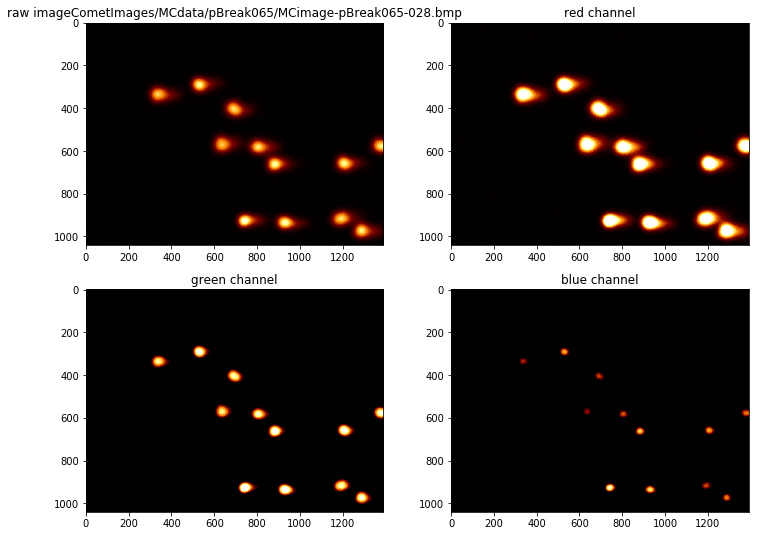

max pix value of edited rg Image is:  255


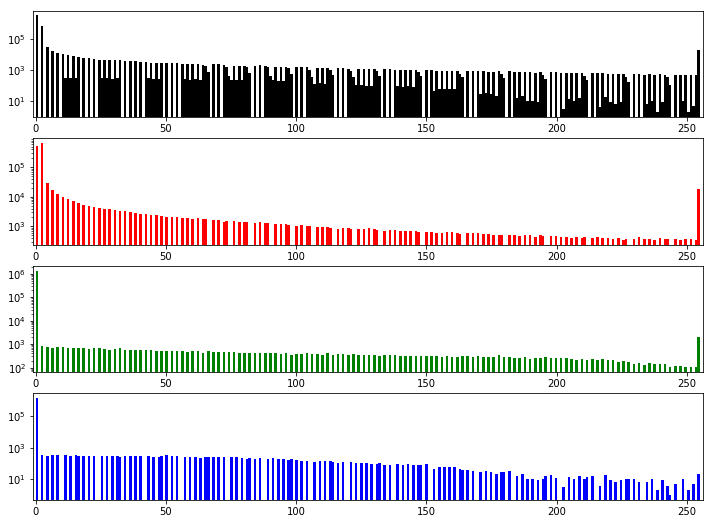

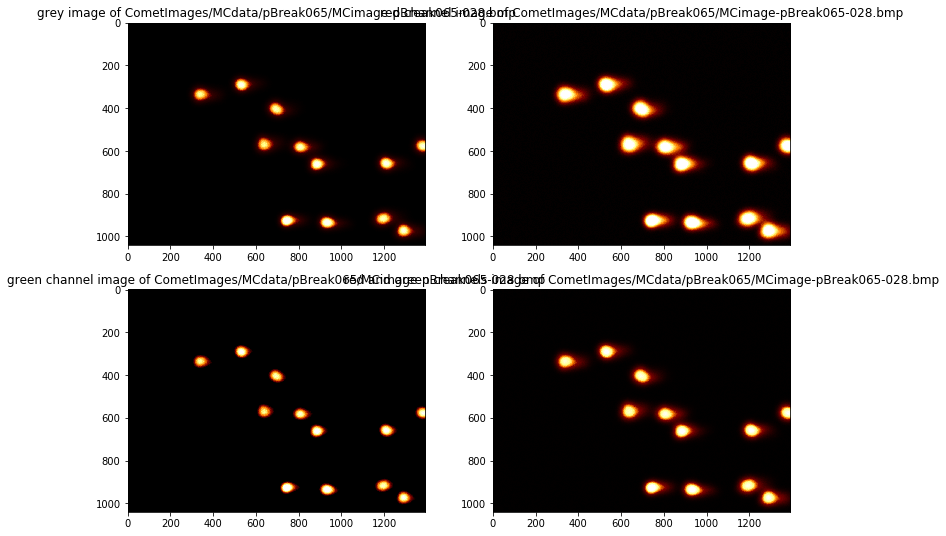

undefined channel for analysis
will use grey image
using threshGrey which is:  [51 80]


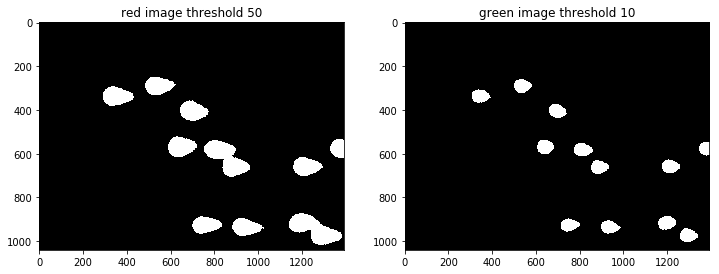

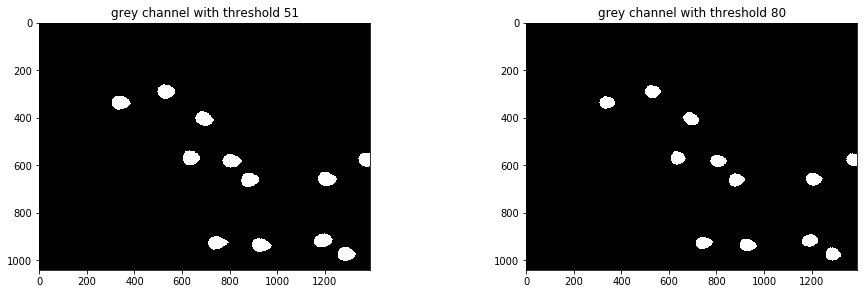

 
Date and time 2021-06-24 13:04:26.367402
Time since last check is 0:00:16.463022


In [41]:
############# RGB Analysis
R, G, B = rgbSeperate(imgRGB, imFile, withPlots = True)

rScale = (R / 254)
gScale = (G / 254)
rg = (((rScale + gScale) *254)/2).astype(int)
#
print("max pix value of edited rg Image is: ", np.max(rg))
plt.figure(figsize = (12, 9))
plt.subplot(2, 2, 1)
plt.title("grey image of " + str(imFile))
plt.imshow(imgGrey, cmap='afmhot')
plt.subplot(2, 2, 2)
plt.title("red channel image of " +str(imFile))
plt.imshow(R, cmap='afmhot')
plt.subplot(2, 2, 3)
plt.title("green channel image of " +str(imFile))
plt.imshow(G, cmap='afmhot')
plt.subplot(2, 2, 4)
plt.title("red and green channels image of " +str(imFile))
plt.imshow(rg, cmap='afmhot')
plt.show()
#
#red variables
rThresh = [50, 170]   
rLow = R > rThresh[0]   #low threshold for comets
rHigh = R > rThresh[1]   #high threshold for heads
#
#green variables
gThresh = [10, 90]  
gLow = G > gThresh[0]
gHigh = G > gThresh[1]
#
#red-green variables
rgThresh = [30, 120]
rgLow = G > gThresh[0]
rgHigh = G > gThresh[1]

plt.figure(figsize = (12, 9))
plt.subplot(1, 2, 1)
plt.title("red image threshold " + str(rThresh[0]))
plt.imshow(rLow, cmap='afmhot')
plt.subplot(1, 2, 2)
plt.title("green image threshold " +str(gThresh[0]))
plt.imshow(gLow, cmap='afmhot')
#
channel = 'grey'
#
if channel == 'red':
    imgGrey = R
    thresh = rThresh
    thrLow = rLow
    thrHigh = rHigh
elif channel == 'green':
    imgGrey = G
    thresh = gThresh
    thrLow = gLow
    thrHigh = gHigh
elif channel == 'red-green':
    imgGrey = rg
    thresh = rgThresh
    thrLow = rgLow
    thrHigh = rgHigh
elif channel == 'rgb':
    imgGrey = imgRGB
    thresh = rgbThresh
    thrLow = rgbLow
    thrHigh = rgbHigh
else:
    print("undefined channel for analysis")
    print("will use grey image")
    imgGrey = imgGrey
    thresh = threshGrey
    thrLow = imgGrey > threshGrey[0]
    thrHigh = imgGrey > threshGrey[1]
    print("using threshGrey which is: ", threshGrey)
#
fig = plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
plt.title(str(channel) + " channel with threshold " + str(thresh[0]))
plt.imshow(thrLow, cmap='afmhot')
plt.subplot(2,2,2)
plt.title(str(channel) + " channel with threshold " + str(thresh[1]))
plt.imshow(thrHigh, cmap='afmhot')
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Edge finding and cluster expansion

Algorithm used is to shift logical array `picture` containing thresholded image left, forming array `imgShift`. The array `not imgShift and picture` then contains the right edges in the original image. Shifts right, down and up allow the left, upper and lower edges to be found. "Corner" effects are taken care of by shifts in two doections (e.g. left and up). Taking the logical or of the results gives all edges.

In [22]:
def edgeFinderIn(picture, edgeWidth, useDiag = True):
    '''
    Return array containing pixels in edges (of width edgeWidth) of input (thresholded) image.
    The edges are inside the original image. The flag useDiag ensures "corner" pixels are selected.
    '''
    #
    shiftR = edgeWidth
    shiftC = edgeWidth
    nRows, nCols = picture.shape
    edges = np.full((nRows, nCols), False)
    imgShift = np.full((nRows, nCols), False)
    #
    # Right edge
    imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
    imgShift[0:nRows, nCols - shiftC:nCols] = False
    edges = np.logical_and(picture, np.logical_not(imgShift))
    #
    # Left edge 
    imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
    imgShift[0:nRows, 0:shiftC] = False
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    # Lower edge 
    imgShift[shiftR:nRows, 0:nCols] = picture[0:nRows - shiftR, 0:nCols]
    imgShift[0:shiftR, 0:nCols] = False    
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    # Upper edge 
    imgShift[0:nRows - shiftR, 0:nCols] = picture[shiftR:nRows, 0:nCols]    
    imgShift[nRows - shiftR:nRows, 0:nCols] = False
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    if useDiag:
        #
        # Left upper edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Left lower edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Right upper edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Right lower edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
    return edges
#
#
def expander(picture, edgeWidth, useDiag = True):
    '''
    Return array containing thresholded regions expanded by band of width edgeWidth. The flag useDiag ensures
    "corner" pixels are included correctly.
    '''
    #
    shiftR = 1
    shiftC = 1
    nRows, nCols = picture.shape
    edges = np.full((nRows, nCols), False)
    edgeSum = np.full((nRows, nCols), False)
    imgShift = np.full((nRows, nCols), False)
    #
    for  nE in range(0, edgeWidth):
        #
        # Left edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        edges = np.logical_and(np.logical_not(picture), imgShift)
        #
        # Right edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        # Upper edge 
        imgShift[shiftR:nRows, 0:nCols] = picture[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        # Lower edge 
        imgShift[0:nRows - shiftR, 0:nCols] = picture[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        if useDiag:
            #
            # Left upper edge
            imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
            imgShift[0:nRows, nCols - shiftC:nCols] = False
            imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
            imgShift[0:shiftR, 0:nCols] = False    
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Left lower edge
            imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
            imgShift[0:nRows, nCols - shiftC:nCols] = False
            imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
            imgShift[nRows - shiftR:nRows, 0:nCols] = False
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Right upper edge 
            imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
            imgShift[0:nRows, 0:shiftC] = False
            imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
            imgShift[0:shiftR, 0:nCols] = False    
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Right lower edge 
            imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
            imgShift[0:nRows, 0:shiftC] = False
            imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
            imgShift[nRows - shiftR:nRows, 0:nCols] = False
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        picture = np.logical_or(picture, edges)
        edgeSum = np.logical_or(edges, edgeSum)
    #
    return picture, edgeSum
#

## Identify clusters using watershed algorithm

Identify "clusters" at the lowest threshold and "heads" at the higher threshold.

Date and time 2021-06-24 11:52:43.910960
 
Cluster ID using Watershed algorithm
Cluster threshold 44, head threshold 80.
Min number of pixels in cluster 200, max number 200000.
Min number of pixels in head 100, max number 20000.
 


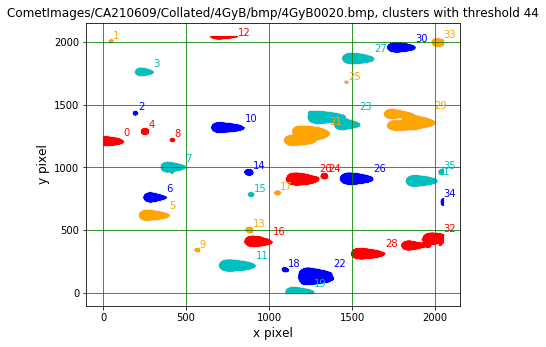

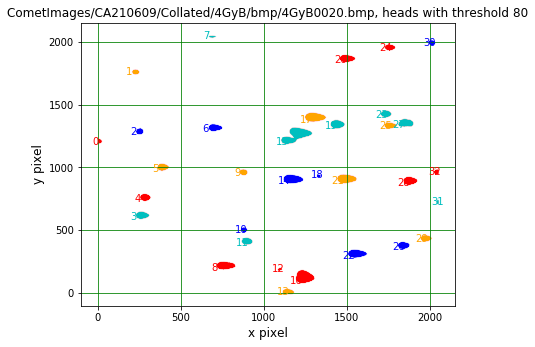

 
Date and time 2021-06-24 11:52:54.837904
Time since last check is 0:00:10.926944


In [23]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
#
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
#
debug = False
#
# Requirements on minimum and maximum number of pixels in wheels at the cluster and head thresholds
minClusPixels = 200
maxClusPixels = 200000
minHeadPixels = 100
maxHeadPixels = 20000
#
print(" ")
print("Cluster ID using Watershed algorithm")
print("Cluster threshold",thresh[0],"\b, head threshold",thresh[1],"\b.")
print("Min number of pixels in cluster",minClusPixels,"\b, max number",maxClusPixels,"\b.")
print("Min number of pixels in head",minHeadPixels,"\b, max number",maxHeadPixels,"\b.")
#
# Define grid of markers and background marker value:
nStepCols = 3
nStepRows = 3
#
# Ensure rMark + 1 (used later) doesn't cause overflow in number of image rows (i.e. rMark + 1 < nRows)
if nRows%nStepRows > 1:
    rMarkTop = nRows
else:
    rMarkTop = nRows - nStepRows
rMark, cMark = np.ogrid[0:rMarkTop:nStepRows, 0:nCols:nStepCols]
if debug:
    print(" ")
    print("rMark.shape",rMark.shape,"cMark.shape",cMark.shape)
mStart = 1
markers = np.zeros((nRows, nCols)).astype(np.int)
markers[rMark, cMark] = rMark/nStepRows + cMark*nRows/(nStepRows*nStepCols) + mStart
if debug:
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(markers, cmap = "CMRmap");
#
# Create image with cluster threshold and run watershed algorithm
#imgGrey = R
clusImg = imgGrey > thresh[0]
if debug:
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(clusImg);
colDotsClus = ndimage.watershed_ift(clusImg.astype(np.uint8), markers)
#
# Remove "isolated" markers (i.e. markers in regions where no cluster found)
#colDotsClus[rMark, cMark] = colDotsClus[rMark + 1, cMark]
colDotsClus[rMark, cMark] = colDotsClus[rMark + 1, cMark]
#
# Find the value of the marker of the last identified regions
mMaxClus = np.amax(colDotsClus)
#
# Positions of marker values
boolClus = colDotsClus >= mStart
nFoundClus = len(np.unique(colDotsClus[boolClus]))
rMarkerClus = np.zeros(nFoundClus)
rMarkerClus = np.unique(colDotsClus[boolClus])
#
# Select the clusters, first pass (determine accepted number). Must exclude tiny clusters (noise) and any 
# really large clusters (background regions in image).
nClus = 0
cMarkerClus = np.zeros(nFoundClus)
maxInDotClus = 0
for nR in range(0, nFoundClus):
    boolClus = colDotsClus == rMarkerClus[nR]
    nHereCl = np.sum(boolClus)
    if nHereCl < minClusPixels or nHereCl > maxClusPixels:
        continue
    maxInDotClus = max(maxInDotClus, nHereCl)
    cMarkerClus[nClus] = rMarkerClus[nR]
    nClus += 1
#
# Create image with head threshold and run watershed algorithm
headImg = imgGrey > thresh[1]
if debug:
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(headImg);
colDotsHead = ndimage.watershed_ift(headImg.astype(np.uint8), markers)
#
# Remove "isolated" markers
colDotsHead[rMark, cMark] = colDotsHead[rMark + 1, cMark]
#
# Find the value of the marker of the last identified regions.
mMaxHead = np.amax(colDotsHead)
#
# Positions of marker values that are not background
boolHead = colDotsHead > mStart
nFoundHead = len(np.unique(colDotsHead[boolHead]))
rMarkerHead = np.zeros(nFoundHead)
rMarkerHead = np.unique(colDotsHead[boolHead])
#
# Select the heads, first pass (determine accepted number). Must exclude tiny clusters (noise) and any 
# really large clusters (background regions in image).
nHead = 0
cMarkerHead = np.zeros(nFoundHead)
maxInDotHead = 0
for nR in range(0, nFoundHead):
    boolHead = colDotsHead == rMarkerHead[nR]
    nHereHd = np.sum(boolHead)
    if nHereHd < minHeadPixels or nHereHd > maxHeadPixels:
        continue
    maxInDotHead = max(maxInDotHead, nHereHd) 
    cMarkerHead[nHead] = rMarkerHead[nR]
    nHead += 1
#
# Colour table for plots
nColTab = 4
colorTab = ['r', 'orange', 'b', 'c']
#
# Information on clusters
nInCluster = np.zeros(nClus).astype(int)
iClusSum = np.zeros(nClus)
#
# Information on pixels in clusters
lClus = np.sum(clusImg)
#
# Safe size of arrays would be number of pixels in image. Try to reduce size by using number of pixels in clusters
# The factor lFact can be used to expand array sizes
lFact = 4
indexCl = np.zeros(lFact*lClus)
cPixelsCl = np.zeros(lFact*lClus).astype(int)
rPixelsCl = np.zeros(lFact*lClus).astype(int)
iPixelsCl = np.zeros(lFact*lClus)
#
# Information on head
nInHead = np.zeros(nHead).astype(int)
iHeadSum = np.zeros(nHead)
#
# Information on pixels in head (lHead must be large enough...here probably larger than usually needed)
lHead = lClus
indexHd = np.zeros(lHead)
cPixelsHd = np.zeros(lHead).astype(int)
rPixelsHd = np.zeros(lHead).astype(int)
iPixelsHd = np.zeros(lHead)
#
# Temporary information 
cPixelsHere = np.zeros(lClus).astype(int)
rPixelsHere = np.zeros(lClus).astype(int)
iPixelsHere = np.zeros(lClus)
thisPic = np.zeros((nRows, nCols))
#
# Find pixels in clusters, determine positions and plot 
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", clusters with threshold " + str(thresh[0]), fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMax = 2
yOffMax = 2
mSize = 0.001
#
nCol = 0
nLastCl = 0
for nC in range(0, nClus):
    #
    # Clusters
    boolClus = colDotsClus == cMarkerClus[nC]
    nHereCl = np.sum(boolClus).astype(int)
    #
    nInCluster[nC] = nHereCl
    #
    # Indices of x and y pixels
    rPixelsHere, cPixelsHere = np.where(boolClus)
    thisPic.fill(0) 
    thisPic[rPixelsHere, cPixelsHere] = 1
    if debug:
        clusPic += thisPic
    #
    # Intensities in pixels
    iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
    iClusSum[nC] = np.sum(iPixelsHere)
    #
    indexCl[nLastCl:nLastCl + nHereCl] = nC*np.ones(nHereCl)
    cPixelsCl[nLastCl:nLastCl + nHereCl] = cPixelsHere[:]
    rPixelsCl[nLastCl:nLastCl + nHereCl] = rPixelsHere[:]
    iPixelsCl[nLastCl:nLastCl + nHereCl] = iPixelsHere[:]
    #
    plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsHere[0:nHereCl]) + yOffMax
    cLab = np.amax(cPixelsHere[0:nHereCl]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastCl = nLastCl + nHereCl
    #
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
# Find pixels in head, determine positions and plot
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", heads with threshold " + str(thresh[1]), fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMin = 15.0
yOffMin = 35.0
mSize = 0.001
#
nCol = 0
nLastHd = 0
for nH in range(0, nHead):
    boolHead = colDotsHead == cMarkerHead[nH]
    nHereHd = np.sum(boolHead).astype(int)
    #
    nInHead[nH] = nHereHd
    #
    # Indices of x and y pixels
    rPixelsHere, cPixelsHere = np.where(boolHead)
    #
    # Intensities in pixels
    iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
    iHeadSum[nH] = np.sum(iPixelsHere)
    #
    indexHd[nLastHd:nLastHd + nHereHd] = nC*np.ones(nInHead[nH])  #
    cPixelsHd[nLastHd:nLastHd + nHereHd] = cPixelsHere[0:nHereHd]
    rPixelsHd[nLastHd:nLastHd + nHereHd] = rPixelsHere[0:nHereHd]
    iPixelsHd[nLastHd:nLastHd + nHereHd] = iPixelsHere[0:nHereHd]
    #
    plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amin(rPixelsHere) - xOffMin
    cLab = np.amin(cPixelsHere) - yOffMin
    plt.text(cLab, rLab, str(nH), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastHd = nLastHd + nHereHd
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Make plots using stored cluster and head data

Date and time 2021-06-24 11:52:54.893378
 


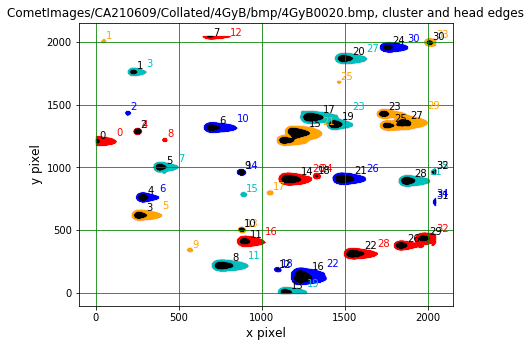

 
Date and time 2021-06-24 11:52:56.848453
Time since last check is 0:00:01.955075


In [24]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", cluster and head edges", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
nCol = 0
#
nLastCl = 0
nLastClEd = 0
for nC in range(0, nClus):
    #
    # Clusters
    nHereCl = nInCluster[nC]
    plt.scatter(cPixelsCl[nLastCl:nLastCl + nHereCl], rPixelsCl[nLastCl:nLastCl + nHereCl], 
                s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsCl[nLastCl:nLastCl + nHereCl]) + yOffMax
    cLab = np.amax(cPixelsCl[nLastCl:nLastCl + nHereCl]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastCl = nLastCl + nHereCl
    #
#
nCol = 0
nLastHd = 0
for nH in range(0, nHead):
    #
    # Heads
    nHereHd = nInHead[nH]
    plt.scatter(cPixelsHd[nLastHd:nLastHd + nHereHd], rPixelsHd[nLastHd:nLastHd + nHereHd], 
                s = mSize, c = 'k', marker = 'o')
    rLab = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd]) + yOffMax
    cLab = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd]) + xOffMax
    plt.text(cLab, rLab, str(nH), color = 'k')
    #
    nLastHd = nLastHd + nHereHd
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Expand clusters and plot

Date and time 2021-06-24 11:52:57.076752
 


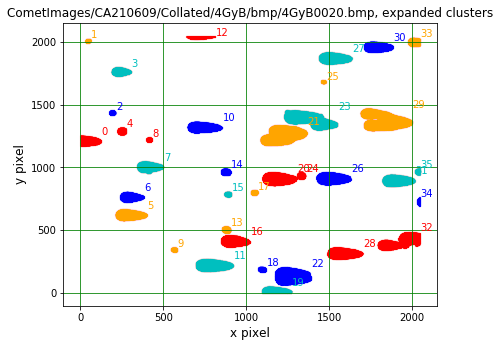

 
Date and time 2021-06-24 11:53:18.511036
Time since last check is 0:00:21.434284


In [25]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
if debug:
    print("Running in debug mode!")
#
useDiag = True
#
# Temporary information 
lFact = 1
cPixelsHere = np.zeros(lFact*lClus).astype(int)
rPixelsHere = np.zeros(lFact*lClus).astype(int)
thisPicEx = np.zeros((nRows, nCols))
thisEdge = np.zeros((nRows, nCols))
#
# Information on expanded cluster
nInClusEx = np.zeros(nClus).astype(int)
iClusExSum = np.zeros(nClus)
#
# Information on pixels in expanded cluster
lFact = 30
indexClEx = np.zeros(lFact*lClus)
cPixelsClEx = np.zeros(lFact*lClus).astype(int)
rPixelsClEx = np.zeros(lFact*lClus).astype(int)
iPixelsClEx = np.zeros(lFact*lClus)
#
# Information on edge
nInEdge = np.zeros(nClus).astype(int)
iEdgeSum = np.zeros(nClus)
#
# Information on pixels in expanded edge
lFact = 3
indexEdge = np.zeros(lFact*lClus)
cPixelsEdge = np.zeros(lFact*lClus).astype(int)
rPixelsEdge = np.zeros(lFact*lClus).astype(int)
iPixelsEdge = np.zeros(lFact*lClus)
#
# Pictures before and after expanding and edges (all clusters)
clusPic = np.zeros((nRows, nCols))
clusPicEx = np.zeros((nRows, nCols))
edgePic = np.zeros((nRows, nCols))
#
# Expansion required
widthEx = 5 #was 10
#
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", expanded clusters", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMax = 2
yOffMax = 2
xOffMin = 30
yOffMin = 30
mSize = 0.001
#
nLastCl = 0
nLastClEx = 0
nLastEdge = 0
nCol = 0
for nC in range(0, nClus):
    #
    # Clusters
    nHereCl = nInCluster[nC]
    #
    # Indices of x and y pixels
    thisPic.fill(0) 
    thisPic[rPixelsCl[nLastCl:nLastCl + nHereCl], cPixelsCl[nLastCl:nLastCl + nHereCl]] = 1
    clusPic += thisPic
    #
    nLastCl = nLastCl + nHereCl
    #
    # Expand cluster
    thisExp, thisEdge = expander(thisPic, widthEx, useDiag)
    nHereClEx = np.sum(thisExp).astype(int)
    nInClusEx[nC] = nHereClEx
    #
    # Indices of x and y pixels expanded cluster
    rPixelsHereEx, cPixelsHereEx = np.where(thisExp)
    thisPicEx.fill(0)
    thisPicEx[rPixelsHereEx, cPixelsHereEx] = 1
    clusPicEx += thisPicEx
    #
    # Intensities in pixels expanded cluster
    iPixelsHereEx = imgGrey[rPixelsHereEx, cPixelsHereEx]
    iClusExSum[nC] = np.sum(iPixelsHereEx)
    #
    indexClEx[nLastClEx:nLastClEx + nHereClEx] = nC*np.ones(nHereClEx)
    cPixelsClEx[nLastClEx:nLastClEx + nHereClEx] = cPixelsHereEx[:]
    rPixelsClEx[nLastClEx:nLastClEx + nHereClEx] = rPixelsHereEx[:]
    iPixelsClEx[nLastClEx:nLastClEx + nHereClEx] = iPixelsHereEx[:]
    #
    plt.scatter(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx], rPixelsClEx[nLastClEx:nLastClEx + nHereClEx], 
                s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + yOffMax
    cLab = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastClEx = nLastClEx + nHereClEx
    #
    # Expanded edges
    nHereEdge = np.sum(thisEdge).astype(int)
    nInEdge[nC] = nHereEdge
    #
    # Indices of x and y pixels edge
    rPixelsHereEdge, cPixelsHereEdge = np.where(thisEdge)
    thisEdge.fill(0)
    thisEdge[rPixelsHereEdge, cPixelsHereEdge] = 1
    edgePic += thisEdge
    #
    # Intensities in pixels edge
    iPixelsHereEdge = imgGrey[rPixelsHereEdge, cPixelsHereEdge]
    iEdgeSum[nC] = np.sum(iPixelsHereEdge)
    #
    indexEdge[nLastEdge:nLastEdge + nHereEdge] = nC*np.ones(nHereEdge)
    cPixelsEdge[nLastEdge:nLastEdge + nHereEdge] = cPixelsHereEdge[:]
    rPixelsEdge[nLastEdge:nLastEdge + nHereEdge] = rPixelsHereEdge[:]
    iPixelsEdge[nLastEdge:nLastEdge + nHereEdge] = iPixelsHereEdge[:]
    nLastEdge = nLastEdge + nHereEdge
    #
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
if debug:
    print(" ")
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(clusPic);
    plt.show()
    print(" ")
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(clusPicEx);
    plt.show()
    print(" ")
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(edgePic);
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot expanded edges

Date and time 2021-06-24 11:53:18.556757
 


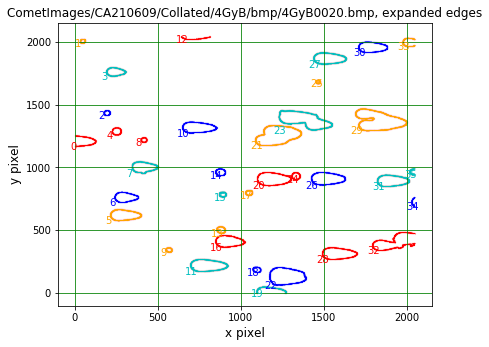

 
Date and time 2021-06-24 11:53:19.202017
Time since last check is 0:00:00.645260


In [26]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
#
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", expanded edges", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMax = 2
yOffMax = 2
xOffMin = 30
yOffMin = 30
mSize = 0.001
#
nLastEdge = 0
nCol = 0
for nC in range(0, nClus):
    #
    # Edges
    nHereEdge = nInEdge[nC]
    #
    plt.scatter(cPixelsEdge[nLastEdge:nLastEdge + nHereEdge], rPixelsEdge[nLastEdge:nLastEdge + nHereEdge], 
                s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amin(rPixelsEdge[nLastEdge:nLastEdge + nHereEdge]) - yOffMin
    cLab = np.amin(cPixelsEdge[nLastEdge:nLastEdge + nHereEdge]) - xOffMin
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastEdge = nLastEdge + nHereEdge
    #
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Find edges of expanded clusters and plot

Date and time 2021-06-24 11:53:19.329414
 


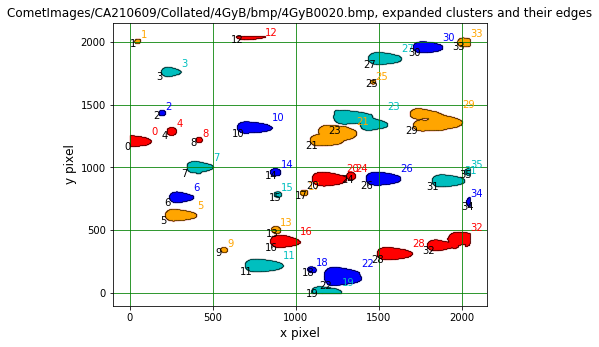

 
Date and time 2021-06-24 11:53:29.681421
Time since last check is 0:00:10.352007


In [27]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
if debug:
    print("Running in debug mode!")
#
useDiag = True
#
clusPic = np.zeros((nRows, nCols))
headPic = np.zeros((nRows, nCols))
#
# Information on cluster edge
nInClusEd = np.zeros(nClus).astype(int)
iClusEdSum = np.zeros(nClus)
#
# Information on pixels in cluster edge
lFact = 1
indexClEd = np.zeros(lFact*lClus)
cPixelsClEd = np.zeros(lFact*lClus)
rPixelsClEd = np.zeros(lFact*lClus)
iPixelsClEd = np.zeros(lFact*lClus)
#
# Pictures for display/edge finding
thisEdge = np.zeros((nRows, nCols))
thisEdgePic = np.zeros((nRows, nCols))
#
# Edge width required
width = 1
#
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", expanded clusters and their edges", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMax = 2
yOffMax = 2
xOffMin = 30
yOffMin = 30
nCol = 0
mSize = 0.001
#
nLastClEx = 0
nLastClEd = 0
for nC in range(0, nClus):
    #
    # Clusters
    nHereClEx = nInClusEx[nC]
    #
    # Indices of x and y pixels
    thisPic.fill(0)
    thisPic[rPixelsClEx[nLastClEx:nLastClEx + nHereClEx], cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]] = 1
    clusPic += thisPic
    #
    plt.scatter(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx], rPixelsClEx[nLastClEx:nLastClEx + nHereClEx],
                s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + yOffMax
    cLab = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    #
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastClEx = nLastClEx + nHereClEx
    #
    # Edges
    thisEdge = edgeFinderIn(thisPic, width, useDiag)
    nHereClEd = np.sum(thisEdge).astype(int)
    #
    nInClusEd[nC] = nHereClEd
    #
    # Indices of x and y pixels
    rPixelsHereEd, cPixelsHereEd = np.where(thisEdge)
    thisEdgePic[rPixelsHereEd, cPixelsHereEd] = 1
    #
    # Intensities in pixels
    iPixelsHereEd = imgGrey[rPixelsHereEd, cPixelsHereEd]
    iClusEdSum[nC] = np.sum(iPixelsHereEd)
    #
    indexClEd[nLastClEd:nLastClEd + nHereClEd] = nC*np.ones(nInClusEd[nC])
    cPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = cPixelsHereEd[0:nHereClEd]
    rPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = rPixelsHereEd[0:nHereClEd]
    iPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = iPixelsHereEd[0:nHereClEd]
    #
    plt.scatter(cPixelsHereEd, rPixelsHereEd, s = mSize, c = 'k', marker = 'o')
    rLab = np.amin(rPixelsHereEd[0:nHereClEd]) - yOffMin
    cLab = np.amin(cPixelsHereEd[0:nHereClEd]) - xOffMin
    plt.text(cLab, rLab, str(nC), color = 'k')
    #
    nLastClEd = nLastClEd + nHereClEd
    #
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
if debug:
    print(" ")
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(clusPic);
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Make image of heads, find their edges and plot

Date and time 2021-06-24 11:53:29.777509
 


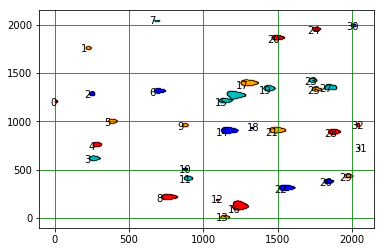

 
Date and time 2021-06-24 11:53:37.825043
Time since last check is 0:00:08.047534


In [28]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
if debug:
    print("Running in debug mode!")
#
# Figure control
xOffMax = 2
yOffMax = 2
xOffMin = 30
yOffMin = 30
nCol = 0
mSize = 0.001
#
# Information on head edge
width = 1
nInHeadEd = np.zeros(nHead).astype(int)
iHeadEdSum = np.zeros(nHead)
#
# Information on pixels in head edge
indexHdEd = np.zeros(lHead)
cPixelsHdEd = np.zeros(lHead).astype(int)
rPixelsHdEd = np.zeros(lHead).astype(int)
iPixelsHdEd = np.zeros(lHead)
#
# Pictures for display/edge finding
headPic = np.zeros((nRows, nCols))
#
nLastHd = 0
nLastHdEd = 0
for nH in range(0, nHead):
    #
    # Heads
    nHereHd = nInHead[nH]
    thisPic.fill(0)
    thisPic[rPixelsHd[nLastHd:nLastHd + nHereHd], cPixelsHd[nLastHd:nLastHd + nHereHd]] = 1
    headPic += thisPic
    #
    plt.scatter(cPixelsHd[nLastHd:nLastHd + nHereHd], rPixelsHd[nLastHd:nLastHd + nHereHd], 
                s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd]) + yOffMax
    cLab = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd]) + xOffMax
    nCol += 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastHd = nLastHd + nHereHd
    #
    # Edges
    thisEdge = edgeFinderIn(thisPic, width, useDiag)
    nHereHdEd = np.sum(thisEdge).astype(int)
    #
    nInHeadEd[nH] = nHereHdEd
    #
    # Indices of x and y pixels
    thisEdgePic.fill(0)
    rPixelsHereEd, cPixelsHereEd = np.where(thisEdge)
    thisEdgePic[rPixelsHereEd, cPixelsHereEd] = 1
    #
    # Intensities in pixels
    iPixelsHereEd = imgGrey[rPixelsHereEd, cPixelsHereEd]
    iHeadEdSum[nH] = np.sum(iPixelsHereEd)
    #
    indexHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = nH*np.ones(nInHeadEd[nH])
    cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = cPixelsHereEd[:]
    rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = rPixelsHereEd[:]
    iPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = iPixelsHereEd[:]
    #
    plt.scatter(cPixelsHereEd, rPixelsHereEd, s = mSize, c = 'k', marker = 'o')
    rLab = np.amin(rPixelsHereEd) - yOffMin
    cLab = np.amin(cPixelsHereEd) - xOffMin
    plt.text(cLab, rLab, str(nH), color = 'k')
    #
    nLastHdEd = nLastHdEd + nHereHdEd
    #
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
if debug:
    print(" ")
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(headPic);
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot expanded clusters and heads together

Note that the index of a head and its associated cluster may be different!

Date and time 2021-06-24 11:53:37.941020
 


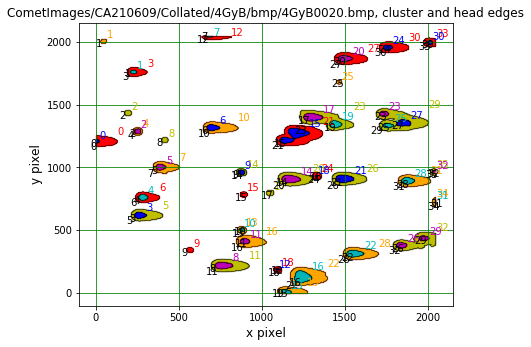

 
Date and time 2021-06-24 11:53:40.528501
Time since last check is 0:00:02.587481


In [29]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
# Figure control
xOffMax = 2
yOffMax = 2
xOffMin = 30
yOffMin = 30
mSize = 0.001
#
# Colour tables for plots
nColTab1 = 3
colorTab1 = ['r', 'orange', 'y']
#
nColTab2 = 3
colorTab2 = ['b', 'c', 'm']
#
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", cluster and head edges", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
nLastClEx = 0
nLastClEd = 0
nCol1 = 0
for nC in range(0, nClus):
    #
    # Clusters
    nHereClEx = nInClusEx[nC]
    plt.scatter(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx], rPixelsClEx[nLastClEx:nLastClEx + nHereClEx],
                s = mSize, c = colorTab1[nCol1], marker = 'o')
    rLab = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + yOffMax
    cLab = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab1[nCol1])
    #
    nCol1 += 1
    if nCol1 > nColTab1 - 1:
         nCol1 = 0
    #
    nLastClEx = nLastClEx + nHereClEx
    #
    # Edges
    nHereClEd = nInClusEd[nC]
    plt.scatter(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd], rPixelsClEd[nLastClEd:nLastClEd + nHereClEd],
                s = mSize, c = 'k', marker = 'o')
    rLab = np.amin(rPixelsClEd[nLastClEd:nLastClEd + nHereClEd]) - yOffMin
    cLab = np.amin(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd]) - xOffMin
    plt.text(cLab, rLab, str(nC), color = 'k')
    #
    nLastClEd = nLastClEd + nHereClEd
    #
nCol2 = 0
#
nLastHd = 0
nLastHdEd = 0
for nH in range(0, nHead):
    #
    # Heads
    nHereHd = nInHead[nH]
    plt.scatter(cPixelsHd[nLastHd:nLastHd + nHereHd], rPixelsHd[nLastHd:nLastHd + nHereHd], 
                s = mSize, c = colorTab2[nCol2], marker = 'o')
    rLab = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd]) + yOffMax
    cLab = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd]) + xOffMax
    plt.text(cLab, rLab, str(nH), color = colorTab2[nCol2])
    nCol2 = nCol2 + 1
    if nCol2 > nColTab2 - 1:
         nCol2 = 0
    #
    # Edges
    nHereHdEd = nInHeadEd[nH]
    plt.scatter(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd], rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd], 
                s = mSize, c = 'k', marker = 'o')
    rLab = np.amin(rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd]) - yOffMin
    cLab = np.amin(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd]) - xOffMin
    plt.text(cLab, rLab, str(nH), color = 'k')
    #
    nLastHd = nLastHd + nHereHd
    nLastHdEd = nLastHdEd + nHereHdEd
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot expanded clusters with original clusters

Can plot all clusters or "zoom in" on specific clusters.

Date and time 2021-06-24 11:53:40.602486
 


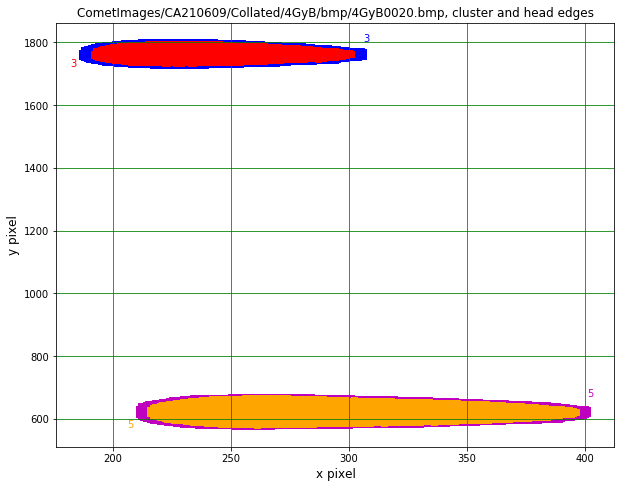

 
Date and time 2021-06-24 11:53:41.144311
Time since last check is 0:00:00.541825


In [30]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
#plotAll = True
plotAll = False
clusList = [3, 5]
#
# Figure control
xOffMax = 0
yOffMax = 0
xOffMin = 10
yOffMin = 10
mSize = 1
#
fig = plt.figure(figsize=(10, 7.8))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", cluster and head edges", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
nLastClEx = 0
nLastCl = 0
nCol1 = 0
nCol2 = 0
for nC in range(0, nClus):
    #
    # Expanded clusters
    nHereClEx = nInClusEx[nC]
    if plotAll or nC in clusList:
        plt.scatter(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx], rPixelsClEx[nLastClEx:nLastClEx + nHereClEx],
                    c = colorTab2[nCol2], marker = ',')
        rLab = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + yOffMax
        cLab = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + xOffMax
        plt.text(cLab, rLab, str(nC), color = colorTab2[nCol2])
        #
        nCol2 += 2
        if nCol2 > nColTab2 - 1:
             nCol2 = 0
    #
    nLastClEx = nLastClEx + nHereClEx
    #
    # Clusters
    nHereCl = nInCluster[nC]
    if plotAll or nC in clusList:
        plt.scatter(cPixelsCl[nLastCl:nLastCl + nHereCl], rPixelsCl[nLastCl:nLastCl + nHereCl],
                    c = colorTab1[nCol1], marker = ',')
        rLab = np.amin(rPixelsCl[nLastCl:nLastCl + nHereCl]) - yOffMin
        cLab = np.amin(cPixelsCl[nLastCl:nLastCl + nHereCl]) - xOffMin
        plt.text(cLab, rLab, str(nC), color = colorTab1[nCol1])
        #
        nCol1 += 1
        if nCol1 > nColTab1 - 1:
             nCol1 = 0
    #
    nLastCl = nLastCl + nHereCl
#
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Select clusters by combining results from all thresholds

Select only low threshold clusters/edges (called wheels/rims in following) containing one high threshold cluster/edge (wheel/rim).

Produce and sort lists of coordinates that will be put into json file as "polygons". Sort according to the angles of the points about the centre of the rim. Choose the centre to be the mean position of the high threshold rim enclosed by the low threshold rim, or the mean position of the pixels in the low threshold rim.

Note that we need to add the first point to the end of the sorted list to close the polygon!

Date and time  2021-06-24 12:48:11.604455
 
Image size 2048 x 2048
Fiducial region, rows 5 to 2043 , columns 5 to 2043
Min number of points in wheel 500 , in rim 100
Rim size, row width 20 to 200 , column width 50 to 500
Max ratio of rim size to wheel area 0.1
 


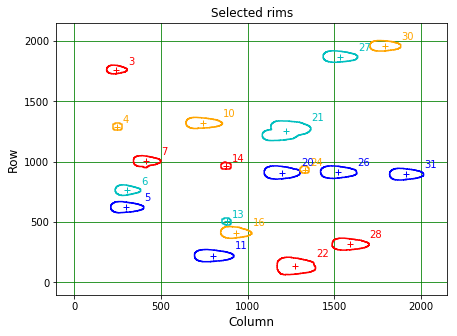

 
Number of polygons (nRimOut) 19
 


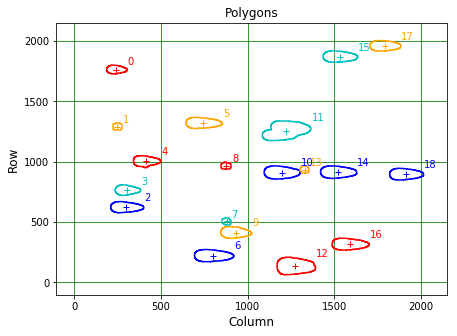

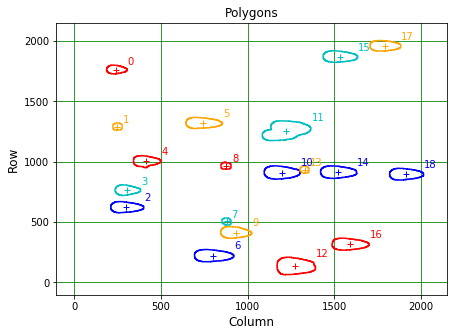

 
Date and time 2021-06-24 12:48:12.564315
Time since last check is 0:00:00.959860


In [33]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
debug = False
#
withLabels = True
#
# Choose low threshold or high threshold rim as centre in sorting procedure
centreLT = True
#
minRimPnts0 = 100
minWheelPnts0 = 500
rMin0 = 5
rMax0 = nRows - rMin0
cMin0 = 5
cMax0 = nCols - cMin0
rWidMin0 = 20
rWidMax0 = 200
cWidMin0 = 50
cWidMax0 = 500
maxRtoW = 0.1
print(" ")
print("Image size",nRows,"x",nCols)
print("Fiducial region, rows",rMin0,"to",rMax0,"\b, columns",cMin0,"to",cMax0)
print("Min number of points in wheel",minWheelPnts0,"\b, in rim",minRimPnts0)
print("Rim size, row width",rWidMin0,"to",rWidMax0,"\b, column width",cWidMin0,"to",cWidMax0)
print("Max ratio of rim size to wheel area",maxRtoW)
#
pnts_num = np.zeros(nClus).astype(int)
pnts_row = np.zeros((nClus, np.amax(nInClusEd)))
pnts_col = np.zeros((nClus, np.amax(nInClusEd)))
mean_row = np.zeros(nClus)
mean_col = np.zeros(nClus)
#
# Need additional entry in sorted arrays as must add initial point at end of array to complete polygon!
col_sorted = np.zeros((nClus, np.amax(nInClusEd) + 1))
row_sorted = np.zeros((nClus, np.amax(nInClusEd) + 1))
#
# Text positions
rTextRow = 3
rTextCol = 3
wTextRow = 28
wTextCol = 28
#
fig = plt.figure(figsize=(7, 5))
plt.title("Selected rims", fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
#
iSelRim = 0
nLastClEx = 0
nLastClEd = 0
for nC in range(0, nClus):
    #
    # Clusters
    nHereClEx = nInClusEx[nC]
    rMinCl = np.amin(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx])
    cMinCl = np.amin(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx])
    rMaxCl = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx])
    cMaxCl = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx])
    rWidCl = rMaxCl - rMinCl
    cWidCl = cMaxCl - cMinCl
    #
    # Edges
    nHereClEd = nInClusEd[nC] 
    rMinClEd = np.amin(rPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
    cMinClEd = np.amin(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
    rMaxClEd = np.amax(rPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
    cMaxClEd = np.amax(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
    rWidClEd = rMaxClEd - rMinClEd
    cWidClEd = cMaxClEd - cMinClEd
    #
    rimToWheel = nInClusEd[nC]/nInClusEx[nC]
    #
    if (nHereClEd > minRimPnts0 and nHereClEx > minWheelPnts0 and
        rMinClEd > rMin0 and rMaxClEd < rMax0 and cMinClEd > cMin0 and cMaxClEd < cMax0 and  
        rWidClEd > rWidMin0 and rWidClEd < rWidMax0 and cWidClEd > cWidMin0 and cWidClEd < cWidMax0 and
        rimToWheel < maxRtoW):
        #
        nHeadsInClus = 0
        #
        nLastHd = 0
        nLastHdEd = 0
        for nH in range(0, nHead):
            #
            # Clusters
            nHereHd = nInHead[nH]
            rMinHd = np.amin(rPixelsHd[nLastHd:nLastHd + nHereHd])
            cMinHd = np.amin(cPixelsHd[nLastHd:nLastHd + nHereHd])
            rMaxHd = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd])
            cMaxHd = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd])
            rWidHd = rMaxHd - rMinHd
            cWidHd = cMaxHd - cMinHd
            #
            # Edges
            nHereHdEd = nInHeadEd[nH]
            rMinHdEd = np.amin(rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
            cMinHdEd = np.amin(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
            rMaxHdEd = np.amax(rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
            cMaxHdEd = np.amax(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
            rWidHdEd = rMaxHdEd - rMinHdEd
            cWidHdEd = cMaxHdEd - cMinHdEd
            #
            # Find any high threshold rims completely within the low threshold rim
            if (rMinHdEd > rMinClEd and rMaxHdEd < rMaxClEd and 
                cMinHdEd > cMinClEd and cMaxHdEd < cMaxClEd):
                #
                nHeadsInClus += 1
                nLastHdSel = nLastHd
                nLastHdEdSel = nLastHdEd
                nHereHdSel = nHereHd
                nHereHdEdSel = nHereHdEd
            #
            nLastHd = nLastHd + nHereHd
            nLastHdEd = nLastHdEd + nHereHdEd
        #
        # End of loop over heads
        #
        if nHeadsInClus == 1:
            # 
            # This rim accepted
            pnts_num[iSelRim] = nHereClEd
            pnts_row[iSelRim, 0:nHereClEd] = rPixelsClEd[nLastClEd:nLastClEd + nHereClEd].astype(int)
            pnts_col[iSelRim, 0:nHereClEd] = cPixelsClEd[nLastClEd:nLastClEd + nHereClEd].astype(int)
            # 
            # Choose desired rim centre for definition of angle used for sorting rim points
            if centreLT:
                mean_row[iSelRim] = np.mean(pnts_row[iSelRim, 0:pnts_num[iSelRim]])
                mean_col[iSelRim] = np.mean(pnts_col[iSelRim, 0:pnts_num[iSelRim]])
            else:
                mean_row[iSelRim] = np.mean(rPixelsHdEd[nLastHdEdSel:nLastHdEdSel + nHereHdEdSel])
                mean_col[iSelRim] = np.mean(cPixelsHdEd[nLastHdEdSel:nLastHdEdSel + nHereHdEdSel])
            #
            atan_pnts = np.arctan2(pnts_col[iSelRim, 0:pnts_num[iSelRim]] - mean_col[iSelRim],
                                   pnts_row[iSelRim, 0:pnts_num[iSelRim]] - mean_row[iSelRim])
            ind_sort = np.argsort(atan_pnts)
            #
            col_sorted[iSelRim, 0:pnts_num[iSelRim]] = pnts_col[iSelRim, ind_sort[0:pnts_num[iSelRim]]]
            row_sorted[iSelRim, 0:pnts_num[iSelRim]] = pnts_row[iSelRim, ind_sort[0:pnts_num[iSelRim]]]
            plt.plot(col_sorted[iSelRim, 0:pnts_num[iSelRim]], row_sorted[iSelRim, 0:pnts_num[iSelRim]],
                     color = colorTab[nCol])
            plt.plot(mean_col[iSelRim], mean_row[iSelRim], marker = '+', color = colorTab[nCol])
            if withLabels:
                row_label = np.amax(pnts_row[iSelRim, 0:pnts_num[iSelRim]]) + rTextRow
                col_label = np.amax(pnts_col[iSelRim, 0:pnts_num[iSelRim]]) + rTextCol
                plt.text(col_label, row_label, str(nC), color = colorTab[nCol])
            nCol = nCol + 1
            if nCol > nColTab - 1:
                 nCol = 0
            #
            iSelRim += 1
        #
        # End of if statement, rim accepted
    #
    # End of if statement, cluster in fiducial region 
    nLastClEx = nLastClEx + nHereClEx
    nLastClEd = nLastClEd + nHereClEd
#
# End of loop over clusters
nRimOut = iSelRim
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
print(" ")
print("Number of polygons (nRimOut)",nRimOut)
#
fig = plt.figure(figsize=(7, 5))
plt.title("Polygons", fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
#
# Add first point (index zero) to end of array to ensure completion of polygon and then plot!
nCol = 0
#
for iRim in range(0, nRimOut):
    col_sorted[iRim, pnts_num[iRim]] = col_sorted[iRim, 0]
    row_sorted[iRim, pnts_num[iRim]] = row_sorted[iRim, 0]
    plt.plot(col_sorted[iRim, 0:pnts_num[iRim]], row_sorted[iRim, 0:pnts_num[iRim]],
                color = colorTab[nCol])
    plt.plot(mean_col[iRim], mean_row[iRim], marker = '+', color = colorTab[nCol])
    if withLabels:
        row_label = np.amax(pnts_row[iRim, 0:pnts_num[iRim]]) + rTextRow
        col_label = np.amax(pnts_col[iRim, 0:pnts_num[iRim]]) + rTextCol
        plt.text(col_label, row_label, str(iRim), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
#plot reduced points polygons################################

fig = plt.figure(figsize=(7, 5))
plt.title("Polygons", fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
#
# Add first point (index zero) to end of array to ensure completion of polygon and then plot!
nCol = 0
reduction = False
if reduction == True:
    #reduce size of pnts array and create new smaller arrays to save into
    pnts_num_reduced = pnts_num // reduction
    col_reduced = np.zeros((nRimOut, (col_sorted.shape[1] // reduction) +1)) #removed +1 from col index
    row_reduced = np.zeros((nRimOut, (col_sorted.shape[1] // reduction) +1)) # ""
    print("col_reduced shape: ", col_reduced.shape)
    #
    for iRim in range(0, nRimOut):
        col_10 = col_sorted[iRim, 0::reduction]
        row_10 = row_sorted[iRim, 0::reduction]
        print("col_10 shape: ", col_10.shape)
        col_reduced[iRim, :] = col_10
        row_reduced[iRim, :] = row_10
        col_reduced[iRim, pnts_num_reduced[iRim]] = col_reduced[iRim, 0]
        row_reduced[iRim, pnts_num_reduced[iRim]] = row_reduced[iRim, 0]
        pnts_num_reduced[iRim] += 1
        plt.plot(col_reduced[iRim, 0:pnts_num_reduced[iRim]], row_reduced[iRim, 0:pnts_num_reduced[iRim]],
                    color = colorTab[nCol])
        plt.plot(mean_col[iRim], mean_row[iRim], marker = '+', color = colorTab[nCol])
        if withLabels:
            row_label = np.amax(pnts_row[iRim, 0:pnts_num[iRim]]) + rTextRow
            col_label = np.amax(pnts_col[iRim, 0:pnts_num[iRim]]) + rTextCol
            plt.text(col_label, row_label, str(iRim), color = colorTab[nCol])
        nCol = nCol + 1
        if nCol > nColTab - 1:
             nCol = 0
else:
    for iRim in range(0, nRimOut):
            col_sorted[iRim, pnts_num[iRim]] = col_sorted[iRim, 0]
            row_sorted[iRim, pnts_num[iRim]] = row_sorted[iRim, 0]
            pnts_num[iRim] += 1
            plt.plot(col_sorted[iRim, 0:pnts_num[iRim]], row_sorted[iRim, 0:pnts_num[iRim]],
                        color = colorTab[nCol])
            plt.plot(mean_col[iRim], mean_row[iRim], marker = '+', color = colorTab[nCol])
            if withLabels:
                row_label = np.amax(pnts_row[iRim, 0:pnts_num[iRim]]) + rTextRow
                col_label = np.amax(pnts_col[iRim, 0:pnts_num[iRim]]) + rTextCol
                plt.text(col_label, row_label, str(iRim), color = colorTab[nCol])
            nCol = nCol + 1
            if nCol > nColTab - 1:
                 nCol = 0
                #
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#

then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Make json file


In [35]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
from IPython.display import JSON
import os
import json
#
im_file = imFile
im_file_size = os.path.getsize(im_file)
dict_name = im_file + str(im_file_size)
number_comets = nRimOut
#
comets = {}
comets[dict_name] = {
    "fileref": "",
    "size": im_file_size,
    "filename": im_file,
    "base64_img_data": "",
    "file_attributes": {},
    "regions": {str(n_comet):
                {"shape_attributes":
                 {"name": "polygon",
                  "all_points_x":
                  col_sorted[n_comet, 0:pnts_num[n_comet]].astype(int).tolist(),
                  "all_points_y":
                  row_sorted[n_comet, 0:pnts_num[n_comet]].astype(int).tolist(),
                 "region_attributes": {}}}
                for n_comet in range(0, number_comets)}
}
#
out_file_name = 'test.json'
with open(out_file_name, 'w') as outfile:
    json.dump(comets, outfile)
#
out_file_size = os.path.getsize(out_file_name)
print(" ")
print("im_file_size",im_file_size)
print("dict_name",dict_name)
print("out_file_size",out_file_size)
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-06-24 12:48:28.083109
 
im_file_size 2453983
dict_name CometImages/CA210609/Collated/4GyB/bmp/4GyB0020.bmp2453983
out_file_size 110088
 
Date and time 2021-06-24 12:48:28.106485
Time since last check is 0:00:00.023376


## Plot polygons on original image

Date and time  2021-06-24 12:57:06.163536
 
 


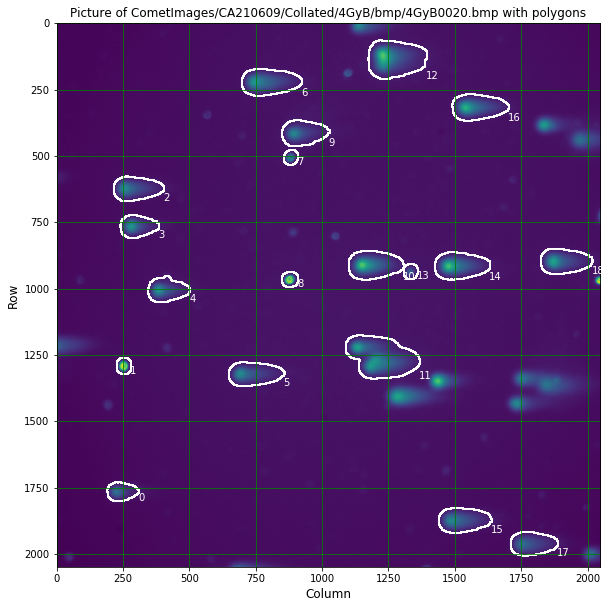

 
Date and time 2021-06-24 12:57:07.365688
Time since last check is 0:00:01.202152


In [39]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
withLabels = True
#
print(" ")
plt.figure(figsize=(14, 10))
plt.title("Picture of " + imFile + " with polygons")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
r_points, c_points = np.indices(imgGrey.shape)
colors = imgGrey.reshape((-1, 4)) #changed from (-1, 3) to (-1, 4)
#plt.scatter(c_points, r_points, c = colors, s = 1)
plt.imshow(imgRaw)
#
for iRim in range(0, nRimOut):
    plt.scatter(col_sorted[iRim, 0:pnts_num[iRim]], row_sorted[iRim, 0:pnts_num[iRim]],
    #plt.scatter(col_reduced[iRim, 0:pnts_num[iRim]], row_reduced[iRim, 0:pnts_num[iRim]], 
                s = 1, marker = ',',c = 'w')
    if withLabels:
        row_label = np.amax(pnts_row[iRim, 0:pnts_num[iRim]])
        col_label = np.amax(pnts_col[iRim, 0:pnts_num[iRim]])
        plt.text(col_label, row_label, str(iRim), color = 'w')
    #
#
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
#print("Time since notebook start is",str(now - startNB))